In [1]:

!pip install bert-for-tf2
!pip install tensorflow-text

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_text as text
from bert import bert_tokenization
import numpy as np
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [3]:

def get_model(model_url, max_seq_length):
  inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
    )

  muril_layer = hub.KerasLayer(model_url, trainable=True)
  outputs = muril_layer(inputs)

  assert 'sequence_output' in outputs
  assert 'pooled_output' in outputs
  assert 'encoder_outputs' in outputs
  assert 'default' in outputs
  return tf.keras.Model(inputs=inputs,outputs=outputs["pooled_output"]), muril_layer

In [4]:
max_seq_length = 128
#muril_model, muril_layer = get_model(model_url="https://tfhub.dev/google/MuRIL/1", max_seq_length=max_seq_length)
path = '/content/drive/MyDrive/Interview/Jatayu/MuRIL_1'
muril_model, muril_layer = get_model(
    model_url=path, max_seq_length=max_seq_length)

In [5]:
vocab_file = muril_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = muril_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [6]:
def create_input(input_strings, tokenizer, max_seq_length):
  input_ids_all, input_mask_all, input_type_ids_all = [], [], []
  for input_string in input_strings:
    input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
    sequence_length = min(len(input_ids), max_seq_length)
    
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    input_type_ids_all.append([0] * max_seq_length)
  
  return np.array(input_ids_all), np.array(input_mask_all), np.array(input_type_ids_all)

In [7]:
def encode(input_text):
  input_ids, input_mask, input_type_ids = create_input(input_text, 
                                                       tokenizer, 
                                                       max_seq_length)
  inputs = dict(
      input_word_ids=input_ids,
      input_mask=input_mask,
      input_type_ids=input_type_ids,
  )
  return muril_model(inputs)

In [8]:
code_mix_sentences = ["मे घर जाऊंगा","मैं घर जा रही हूँ","i am going home",'main ghar ja raha hoon','apka naam kya hai']

In [9]:
code_mix_embedding = encode(code_mix_sentences)

In [10]:
dst_1 = cosine_similarity(np.array(code_mix_embedding[0]).reshape(1,-1), 
                           np.array(code_mix_embedding[1]).reshape(1,-1))
print("SIMILARITY between {} & {} is {}".format(code_mix_sentences[0],
                                                code_mix_sentences[1],
                                                dst_1))

SIMILARITY between मे घर जाऊंगा & मैं घर जा रही हूँ is [[0.99946475]]


In [11]:
dst_1 = cosine_similarity(np.array(code_mix_embedding[0]).reshape(1,-1), 
                           np.array(code_mix_embedding[2]).reshape(1,-1))
print("SIMILARITY between {} & {} is {}".format(code_mix_sentences[0],
                                                code_mix_sentences[2],
                                                dst_1))

SIMILARITY between मे घर जाऊंगा & i am going home is [[0.99958205]]


In [12]:
new_sentences = ["Today is cold", "मैंने उससे दोबारा बात नहीं की है.", "ਮੌਸਮ ਬਹੁਤ ਵਧੀਆ ਹੈ", "ఈ రోజు చాలా చల్లగా ఉంది" ]

In [13]:
new_emb = encode(new_sentences)

In [14]:
dst_11 = cosine_similarity(np.array(code_mix_embedding[0]).reshape(1,-1), 
                           np.array(code_mix_embedding[-1]).reshape(1,-1))
print("Distance between {} & {} is {}".format(new_sentences[0],
                                                new_sentences[-1],
                                                dst_11))

Distance between Today is cold & ఈ రోజు చాలా చల్లగా ఉంది is [[0.9990311]]


In [15]:
import codecs
import random

import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = codecs.open("hindi_stopwords.txt", "r", encoding='utf-8', errors='ignore').read().split('\n')


In [16]:

pos_reviews = codecs.open("pos_hindi.txt", "r", encoding='utf-8', errors='ignore').read()
neg_reviews = codecs.open("neg_hindi.txt", "r", encoding='utf-8', errors='ignore').read()
documents = []
pos_count = 0
for i in pos_reviews.split('$'):
    data = i.strip('\n')
    if data:
        documents.append(data)
        pos_count += 1
neg_count = 0
for i in neg_reviews.split('$'):
    data = i.strip('\n')
    if data:
        documents.append(data)
        neg_count += 1


In [17]:
positive_feature_set = encode(documents[0:pos_count])

In [18]:
negative_set = encode(documents[pos_count:])

In [19]:
SAMP_POS = np.array(positive_feature_set[0]).reshape(1,-1)
SAMP_POS.shape

(1, 768)

In [20]:
pos_set = positive_feature_set.numpy()
neg_set = negative_set.numpy()

In [21]:
print(positive_feature_set.shape)
print(negative_set.shape)

(502, 768)
(494, 768)


In [22]:

finalset = []
for i in pos_set:
    finalset.append([i, 1])
for i in neg_set:
    finalset.append([i, 0])

finalset = np.array(finalset)
random.shuffle(finalset)
test_size = 0.2
testing_size = int((1 - test_size) * len(finalset))
x_train = list(finalset[:, 0][:testing_size])  # taking features array upto testing_size
y_train = list(finalset[:, 1][:testing_size])
x_test = list(finalset[:, 0][testing_size:])
y_test = list(finalset[:, 1][testing_size:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [24]:

lr=LogisticRegression(C=0.01,solver='liblinear').fit(x_train,y_train)
lr


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
y_lr=lr.predict(x_test)
y_lr[:1000]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

syntax gutru led

In [26]:

print('Model Accuracy:', metrics.accuracy_score(y_test,y_lr))


Model Accuracy: 0.53


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
rnd_state = 42
skfold = StratifiedKFold(n_splits=5)

In [28]:
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_curve, auc, roc_auc_score,jaccard_similarity_score,f1_score
forest_clf = RandomForestClassifier(random_state=rnd_state, n_estimators=10)
forest_clf.fit (x_train, y_train)
forest_pred = forest_clf.predict(x_test)
print(accuracy_score(y_test,forest_pred))

0.6


In [29]:
from scipy.stats import randint
param_distribs = {
        'n_estimators': randint(low=100, high=300),
        'max_features': randint(low=8, high=17),
    }

rnd_forest_clf = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=skfold, scoring='accuracy', random_state=rnd_state)
rnd_forest_clf.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_sp...
                     

In [30]:
rnd_forest_clf.best_params_

{'max_features': 14, 'n_estimators': 279}

In [31]:
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_curve, auc, roc_auc_score,jaccard_similarity_score,f1_score
forest_clf = RandomForestClassifier(random_state=rnd_state, n_estimators=203,max_features=11)
forest_clf.fit (x_train, y_train)
forest_pred = forest_clf.predict(x_test)
print(classification_report(y_test,forest_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.24        94
           1       0.57      1.00      0.72       106

    accuracy                           0.59       200
   macro avg       0.78      0.57      0.48       200
weighted avg       0.77      0.59      0.50       200



In [32]:
print(accuracy_score(forest_pred,y_test))

0.595


In [33]:
print(confusion_matrix(y_test,forest_pred))

[[ 13  81]
 [  0 106]]


In [34]:
import pickle

filename = 'random_forest.pkl'
pickle.dump(forest_clf, open(filename, 'wb'))

In [35]:
import tensorflow as tf
import tempfile
import zipfile
import os
import h5py
import numpy as np
import glob
from numpy import linalg as LA
from scipy.stats import rankdata
from shutil import copyfile, move
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten , InputLayer
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
positive_feature_set = encode(documents[0:pos_count])
negative_set = encode(documents[pos_count:])

In [40]:
finalset = []
for i in positive_feature_set:
    finalset.append([np.array(i).reshape((1,768)).tolist(), 1])
for i in negative_set:
    finalset.append([np.array(i).reshape((1,768)).tolist(), 0])

finalset = np.array(finalset)
random.shuffle(finalset)
test_size = 0.2
testing_size = int((1 - test_size) * len(finalset))
x_train = np.array(finalset[:, 0][:testing_size]).tolist()  # taking features array upto testing_size
y_train = np.array(finalset[:, 1][:testing_size]).tolist()
x_test = np.array(finalset[:, 0][testing_size:]).tolist()
y_test = np.array(finalset[:, 1][testing_size:]).tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [41]:
# Define the model(Sequential)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape =  (1,768)))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2,activation=tf.nn.softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            98432     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 2)              258       
Total params: 115,202
Trainable params: 115,202
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])


In [43]:
#ready for erro
model.fit(x_train, y_train,
          batch_size=16,
          epochs=75
          )

Epoch 1/75
50/50 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5443
Epoch 2/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5636
Epoch 3/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4878
Epoch 4/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4871
Epoch 5/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5256
Epoch 6/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5270
Epoch 7/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5158
Epoch 8/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5133
Epoch 9/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5481
Epoch 10/75
50/50 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5847
Epoch 11/75
50/50 [

In [44]:

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6931469440460205
Test accuracy: 0.41499999165534973


In [45]:
y_preds = model.predict(x_test)

In [46]:
y_preds[:3]

array([[[0.500055  , 0.49994498]],

       [[0.5000353 , 0.4999647 ]],

       [[0.5000612 , 0.4999388 ]]], dtype=float32)

In [47]:
from sklearn.metrics import classification_report,confusion_matrix
y_preds = model.predict_classes(x_test)
print(confusion_matrix(y_preds,y_test))
print(classification_report(y_preds,y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 80 115]
 [  2   3]]
              precision    recall  f1-score   support

           0       0.98      0.41      0.58       195
           1       0.03      0.60      0.05         5

    accuracy                           0.41       200
   macro avg       0.50      0.51      0.31       200
weighted avg       0.95      0.41      0.56       200



In [48]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
# %matplotlib inline

In [49]:
def RNN():
    inputs = Input(name='inputs',shape=(1,768))
    layer = LSTM(64)(inputs)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [50]:

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1, 768)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                213248    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0   

In [51]:
model.fit(x_train,y_train,batch_size=8,epochs=10,validation_data = (x_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000001)])

Epoch 1/10
100/100 [==============================] - 4s 18ms/step - loss: 0.4087 - accuracy: 0.8943 - val_loss: 1.1283 - val_accuracy: 0.5900
Epoch 2/10
100/100 [==============================] - 1s 6ms/step - loss: 0.2796 - accuracy: 0.9225 - val_loss: 1.1749 - val_accuracy: 0.5900


In [52]:
accr = model.evaluate(x_test,y_test)
print(accr)

7/7 [==============================] - 0s 4ms/step - loss: 1.1749 - accuracy: 0.5900
[1.1748751401901245, 0.5899999737739563]


In [53]:
y_preds = model.predict(x_test)

In [54]:
y_preds[:2]

array([[0.9377342 ],
       [0.93757915]], dtype=float32)

In [55]:
y_pred = y_preds > 0.5


In [56]:
pred = np.array([1 if i== True else 0 for i in y_pred])
pred[:2]

array([1, 1])

In [57]:
pred[:1000]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [58]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(pred,y_test))
print(classification_report(pred,y_test))

[[  0   0]
 [ 82 118]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.59      0.74       200

    accuracy                           0.59       200
   macro avg       0.50      0.29      0.37       200
weighted avg       1.00      0.59      0.74       200



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [60]:
train_df.head(5)

,text,experience
0,चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्ष...,2
1,अगर आप इस फिल्म को देखने जा रहे हैं तो सबसे पह...,0
2,बॉलीवुड वाले चोरी-छिपे हॉलीवुड फिल्मों से कहान...,2
3,"बैनर :\nसंजय दत्त प्रोडक्शन्स प्रा.लि., रुपाली...",0
4,1959 में घटित चर्चित नानावटी कांड में एक क्राइ...,1


#GLHF

In [61]:
neutral_index = train_df[train_df['experience'] == 1].index

In [62]:
train_df.drop(neutral_index, inplace = True) 

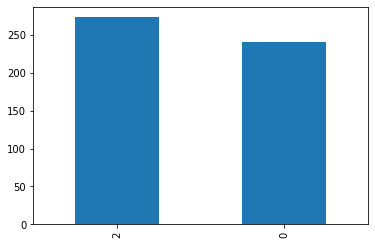

In [63]:
train_df['experience'].value_counts().plot(kind = 'bar')

In [64]:
X = train_df['text'].values
y = train_df['experience'].values

In [67]:
pos_doc = train_df[train_df['experience']==2].text.values
neg_doc = train_df[train_df['experience']==0].text.values

In [68]:
positive_feature_set = encode(pos_doc)

In [69]:
negative_set = encode(neg_doc)

In [70]:
finalset = []
for i in positive_feature_set:
    finalset.append([np.array(i).reshape((1,768)).tolist(), 1])
for i in negative_set:
    finalset.append([np.array(i).reshape((1,768)).tolist(), 0])

finalset = np.array(finalset)
random.shuffle(finalset)
test_size = 0.2
testing_size = int((1 - test_size) * len(finalset))
x_train = np.array(finalset[:, 0][:testing_size]).tolist()  # taking features array upto testing_size
y_train = np.array(finalset[:, 1][:testing_size]).tolist()
x_test = np.array(finalset[:, 0][testing_size:]).tolist()
y_test = np.array(finalset[:, 1][testing_size:]).tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [71]:
# Define the model(Sequential)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape =  (1,768)))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2,activation=tf.nn.softmax))
#chudu idi last layer softmax kada 0 or 1 vastadi kada?
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 128)            98432     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1, 2)              258       
Total params: 115,202
Trainable params: 115,202
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])


In [73]:
#ready for erro
model.fit(x_train, y_train,
          batch_size=32,
          epochs=100
          )

Epoch 1/100
13/13 [==============================] - 1s 6ms/step - loss: 0.6932 - accuracy: 0.4037
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5135
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4889
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4445
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4548
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.6143
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4938
Epoch 8/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5293
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4882
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4912
Epoch 11/

In [74]:
y_preds = model.predict_classes(x_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [75]:
y_preds[:3]

array([[1],
       [1],
       [1]])

In [76]:

model1 = RNN()
model1.summary()
model1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1, 768)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                213248    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0   

In [77]:
model1.fit(x_train,y_train,batch_size=16,epochs=10,validation_data = (x_test,y_test),callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000001)])

Epoch 1/10
26/26 [==============================] - 3s 42ms/step - loss: 0.5306 - accuracy: 0.8412 - val_loss: 1.0803 - val_accuracy: 0.5243
Epoch 2/10
26/26 [==============================] - 0s 8ms/step - loss: 0.3009 - accuracy: 0.9130 - val_loss: 1.3775 - val_accuracy: 0.5243


In [78]:
y_preds = model1.predict(x_test)

In [79]:
y_pred = y_preds > 0.5

In [80]:
pred = 1 * y_pred

In [81]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(pred,y_test))
print(classification_report(pred,y_test))

[[ 0  0]
 [49 54]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.69       103

    accuracy                           0.52       103
   macro avg       0.50      0.26      0.34       103
weighted avg       1.00      0.52      0.69       103



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
model1.save('simple_lstm')

INFO:tensorflow:Assets written to: simple_lstm/assets


INFO:tensorflow:Assets written to: simple_lstm/assets


In [83]:
!zip -r simple_lstm.zip simple_lstm

  adding: simple_lstm/ (stored 0%)
  adding: simple_lstm/variables/ (stored 0%)
  adding: simple_lstm/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: simple_lstm/variables/variables.index (deflated 62%)
  adding: simple_lstm/saved_model.pb (deflated 90%)
  adding: simple_lstm/assets/ (stored 0%)


In [84]:
pickle_in = open("random_forest.pkl","rb")
classifier=pickle.load(pickle_in)

In [85]:
new_str = 'टिफिन खोलते और व्यंजनों की सूंघते-छूते समय इरफान के चेहरे पर संचरित भाव अंतस की खुशी जाहिर करता है'

In [86]:
encoded_str = encode([new_str])

In [87]:
final = np.array(encoded_str)
final[:3]

array([[ 9.32767615e-03,  1.90732460e-02, -7.31219212e-03,
         1.40849473e-02, -7.37197837e-03, -8.89855158e-03,
        -2.06369231e-03, -4.53736354e-03, -3.47176660e-03,
        -9.11292247e-03, -9.24616586e-03,  4.98202536e-03,
         4.40040953e-04,  4.41376964e-04, -4.72436380e-03,
         1.73553601e-02,  2.19460833e-03, -9.29635949e-03,
         3.76882614e-04, -5.58826048e-03,  6.46041520e-03,
         3.62538034e-04,  6.34168135e-03, -2.41714027e-02,
         5.88775054e-03,  1.21208653e-03, -7.22304545e-03,
        -5.78225031e-03, -1.58772978e-04, -2.29967721e-02,
         1.33131929e-02,  1.54866353e-02,  5.52231260e-03,
        -1.57608949e-02,  2.23801024e-02,  7.28015183e-03,
         8.16249102e-03, -1.42357098e-02,  6.84540300e-03,
        -6.86647557e-03, -2.17393562e-02, -1.64093357e-02,
         2.91229342e-03,  1.98938027e-02, -2.10035518e-02,
        -1.28973380e-03, -3.11646960e-03, -1.28301103e-02,
        -5.32301469e-03, -1.11437088e-03, -9.77443345e-0

In [88]:
encoded_str

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 9.32767615e-03,  1.90732460e-02, -7.31219212e-03,
         1.40849473e-02, -7.37197837e-03, -8.89855158e-03,
        -2.06369231e-03, -4.53736354e-03, -3.47176660e-03,
        -9.11292247e-03, -9.24616586e-03,  4.98202536e-03,
         4.40040953e-04,  4.41376964e-04, -4.72436380e-03,
         1.73553601e-02,  2.19460833e-03, -9.29635949e-03,
         3.76882614e-04, -5.58826048e-03,  6.46041520e-03,
         3.62538034e-04,  6.34168135e-03, -2.41714027e-02,
         5.88775054e-03,  1.21208653e-03, -7.22304545e-03,
        -5.78225031e-03, -1.58772978e-04, -2.29967721e-02,
         1.33131929e-02,  1.54866353e-02,  5.52231260e-03,
        -1.57608949e-02,  2.23801024e-02,  7.28015183e-03,
         8.16249102e-03, -1.42357098e-02,  6.84540300e-03,
        -6.86647557e-03, -2.17393562e-02, -1.64093357e-02,
         2.91229342e-03,  1.98938027e-02, -2.10035518e-02,
        -1.28973380e-03, -3.11646960e-03, -1.28301103e-02,
      

In [89]:
pred_ = classifier.predict(final)

In [90]:
pred_

array([1])